<a href="https://colab.research.google.com/github/alexttrt/team5_mobilenetv3/blob/main/MOBILEV3NET%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: CNN

Dataset: custom dataset

In [1]:
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os # path
from glob import glob # search file paths
from tqdm.auto import tqdm # (optional) progress bar
from sklearn.model_selection import train_test_split
import shutil

# PyTorch
import torch
from torch import nn
import torchvision
from torchsummary import summary # model summary

In [2]:
torch.__version__

'2.0.1+cu118'

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device}")

Using: cuda


#### Download dataset

In [4]:
!pip install --upgrade gdown
!gdown --id 1orrhEFRwBmuQbGWhmRYCz6Ehup0xk2Nd --output firstdata.zip
!unzip firstdata.zip

串流輸出內容已截斷至最後 5000 行。
         continuing with "central" filename version
  inflating: 第一次訓練資料/橘貓/istockphoto-1373126887-612x612.jpg  
第一次訓練資料/橘貓/istockphoto-1376642063-612x612.jpg:  mismatching "local" filename (чммф╕АцмбшиУч╖┤ш│ЗцЦЩ/цйШш▓У/istockphoto-1376642063-612x612.jpg),
         continuing with "central" filename version
  inflating: 第一次訓練資料/橘貓/istockphoto-1376642063-612x612.jpg  
第一次訓練資料/橘貓/istockphoto-1382952533-612x612.jpg:  mismatching "local" filename (чммф╕АцмбшиУч╖┤ш│ЗцЦЩ/цйШш▓У/istockphoto-1382952533-612x612.jpg),
         continuing with "central" filename version
  inflating: 第一次訓練資料/橘貓/istockphoto-1382952533-612x612.jpg  
第一次訓練資料/橘貓/istockphoto-1384259784-612x612.jpg:  mismatching "local" filename (чммф╕АцмбшиУч╖┤ш│ЗцЦЩ/цйШш▓У/istockphoto-1384259784-612x612.jpg),
         continuing with "central" filename version
  inflating: 第一次訓練資料/橘貓/istockphoto-1384259784-612x612.jpg  
第一次訓練資料/橘貓/istockphoto-1385217969-612x612.jpg:  mismatching "local" filename (чммф╕АцмбшиУч╖┤ш│

### Data

In [5]:
IMG_SIZE = 256
NUM_CLASS = 7
all_calsses = ["black","white","orange","tuxedo","tortoiseshell","calico","tabby"]
class_map = {cls : i for i, cls in enumerate(all_calsses)}
class_map

{'black': 0,
 'white': 1,
 'orange': 2,
 'tuxedo': 3,
 'tortoiseshell': 4,
 'calico': 5,
 'tabby': 6}

In [8]:
if not os.path.exists("cat_test"):
  for i in all_calsses:
    os.makedirs(f"cat_test/{i}")

In [9]:
for i in range(60):
  for cat in all_calsses:
    img_path = sorted(glob(f"/content/第一次訓練資料/{cat}/*.jpg"))
    dest = f"/content/cat_test/{cat}"
    idx = np.random.randint(len(img_path))
    files = img_path[idx]
    shutil.move(files, dest)

In [10]:
img_path[0:3]

['/content/第一次訓練資料/tabby/istockphoto-1006700906-612x612.jpg',
 '/content/第一次訓練資料/tabby/istockphoto-1010191604-612x612.jpg',
 '/content/第一次訓練資料/tabby/istockphoto-1010539662-612x612.jpg']

In [16]:
img_path_train = sorted(glob(f"/content/第一次訓練資料/*/*.jpg"))
img_path_test = sorted(glob(f"/content/cat_test/*/*.jpg"))
len(img_path_train), len(img_path_test)

(1696, 420)

In [17]:
import pandas as pd
import numpy as np

df_train = pd.DataFrame(columns=["a","b","c","d","e"])
for i in range(len(img_path_train)):
  x = img_path_train[i].split("/")
  x = np.array(x)
  df_train.loc[i] = x

df_test = pd.DataFrame(columns=["a","b","c","d","e"])
for i in range(len(img_path_test)):
  x = img_path_test[i].split("/")
  x = np.array(x)
  df_test.loc[i] = x

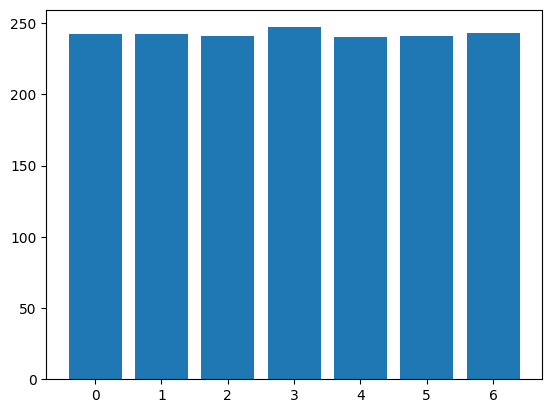

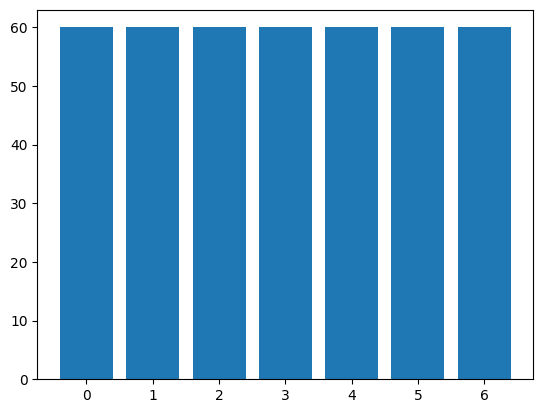

In [18]:
# draw class distribution
def plot_distibution(df):
    values, counts = np.unique(df["d"], return_counts=True)
    plt.bar(range(len(values)), counts)
    plt.show()

plot_distibution(df_train)
plot_distibution(df_test)

/content/第一次訓練資料/tabby/istockphoto-1208122160-612x612.jpg
(408, 612, 3)


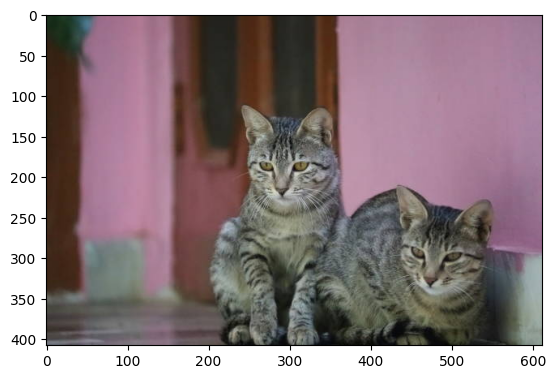

In [19]:
# 秀出圖片
idx = np.random.randint(len(img_path_train))
path = img_path_train[idx]
print(path)
img = Image.open(path).convert("RGB")
img_np = np.array(img)
print(img_np.shape)
plt.imshow(img)

照片大小: (420, 612, 3)
路徑: /content/第一次訓練資料/black/istockphoto-1305780541-612x612.jpg
類別: black


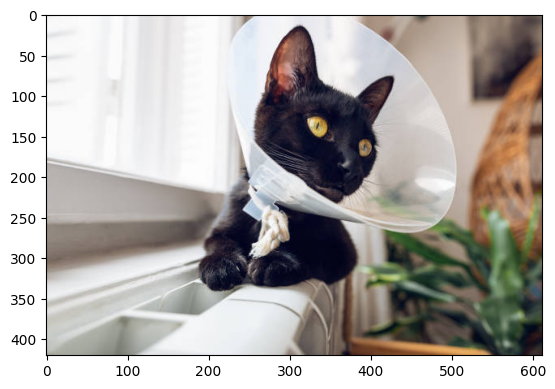

In [21]:
path = img_path_train[105]
img = Image.open(path).convert("RGB")
img_np = np.array(img)/255
print("照片大小:",img_np.shape)
print("路徑:",path)
path.split(os.sep)
cls = path.split(os.sep)[-2]
print("類別:",cls)
plt.imshow(img)

In [22]:
filename = path.split("/")[-1]
cls_cat = path.split("/")[-2]
cls = class_map[cls_cat]
print(filename)
print(cls_cat)
print(cls)

istockphoto-1305780541-612x612.jpg
black
0


#### Dataset & DataLoader


*   [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset)



*   Must implement

    1.   **\_\_len\_\_()**: size of dataset
    2.   **\_\_getitem\_\_()**: load a data sample for a given index

*   \_\_getitem\_\_() steps:
    1. Get image path
    2. Read image, resize
    3. Real image label
    4. convert image to tesnor and rescale to 0~1


ref: [Datasets & DataLoaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)


Pixel value rescale

*   0~1
*   -1~+1 : (x/127.5) - 1
* (x-x.mean()) / x.std()

In [23]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, img_size, class_map):
        self.img_paths = img_paths
        self.img_size = img_size
        self.class_map = class_map

    def __len__(self):
        """number of samples"""
        return len(self.img_paths)

    def __getitem__(self, idx):
        """read 1 sample"""
        # Read img
        path = self.img_paths[idx] # get img path
        img = cv2.imread(path) # read img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
        img = cv2.resize(img, (self.img_size, self.img_size)) # Resize iamge
        img = img / 255. # 0~255 -> 0.~1.

        # Read class index
        cls = path.split(os.sep)[-2]
        # for pneumonia class
        filename = path.split("/")[-1]
        cls = path.split("/")[-2]
        cls_idx = self.class_map[cls]

        # transform img to tensor
        img = torch.tensor(img, dtype=torch.float)
        # channel last -> channel first
        # np.swapaxis()
        img = img.permute(2, 0, 1) # (H, W, C) -> (C, H, W)

        cls_idx = torch.tensor(cls_idx, dtype=torch.long)

        return img, cls_idx

In [24]:
# Build dataset
train_ds = Dataset(img_path_train, IMG_SIZE, class_map)
val_ds = Dataset(img_path_test, IMG_SIZE, class_map)

In [25]:
# Number of samples
len(train_ds), len(val_ds)

(1696, 420)

torch.Size([3, 256, 256]) tensor(0) black


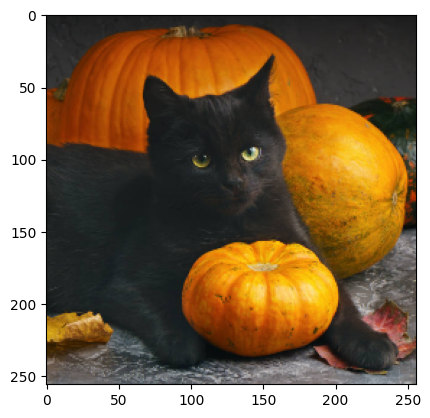

In [26]:
img, label = train_ds[230]
print(img.shape, label, all_calsses[label])

img = img.permute(1, 2, 0) # (C, H, W) -> (H, W, C)
plt.imshow(img)

In [27]:
img, label

(tensor([[[0.1176, 0.1255, 0.1216],
          [0.1176, 0.1255, 0.1216],
          [0.1255, 0.1333, 0.1294],
          ...,
          [0.1059, 0.1059, 0.1059],
          [0.1020, 0.1020, 0.1020],
          [0.1020, 0.1020, 0.1020]],
 
         [[0.1255, 0.1333, 0.1294],
          [0.1216, 0.1294, 0.1255],
          [0.1255, 0.1333, 0.1294],
          ...,
          [0.1098, 0.1098, 0.1098],
          [0.1059, 0.1059, 0.1059],
          [0.1059, 0.1059, 0.1059]],
 
         [[0.1333, 0.1451, 0.1373],
          [0.1255, 0.1333, 0.1294],
          [0.1255, 0.1333, 0.1294],
          ...,
          [0.1137, 0.1137, 0.1137],
          [0.1059, 0.1059, 0.1059],
          [0.1059, 0.1059, 0.1059]],
 
         ...,
 
         [[0.4078, 0.3765, 0.3333],
          [0.4000, 0.3647, 0.3373],
          [0.3961, 0.3569, 0.3451],
          ...,
          [0.4902, 0.4824, 0.4863],
          [0.4549, 0.4510, 0.4431],
          [0.4353, 0.4314, 0.4196]],
 
         [[0.4902, 0.4863, 0.4745],
          [0

In [28]:
# Build DataLoaders
BATCH_SIZE = 32
train_loader = torch.utils.data.DataLoader(train_ds, BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds, BATCH_SIZE)

In [29]:
for (x, y) in val_loader:
    print(x.shape, y)

torch.Size([32, 3, 256, 256]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([32, 3, 256, 256]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 5, 5, 5, 5])
torch.Size([32, 3, 256, 256]) tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        5, 5, 5, 5, 5, 5, 5, 5])
torch.Size([32, 3, 256, 256]) tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
        2, 2, 2, 2, 2, 2, 2, 2])
torch.Size([32, 3, 256, 256]) tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])
torch.Size([32, 3, 256, 256]) tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])
torch.Size([32, 3, 256, 256]) tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6])

### Model



*   Must implement
    1.   **\_\_init\_\_**(): layer **initialization**
    2.   **forward**(): connect **Input** to **Output**



*   Model architecture
    1.   Feature extractor (encoder)
    2.   Flatten
    3.   Classifier



In [30]:
from torchvision.models import mobilenet_v3_small
from torchvision.models import MobileNet_V3_Small_Weights
model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.DEFAULT).to(device)
model.classifier = nn.Sequential(
    nn.Linear(in_features=576, out_features=1024),
    nn.Hardswish(),
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1024, out_features=7),
).to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 17.1MB/s]


In [31]:
summary(model, (3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
         Hardswish-3         [-1, 16, 128, 128]               0
            Conv2d-4           [-1, 16, 64, 64]             144
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 64, 64]               0
           Conv2d-13           [-1, 16, 64, 64]             256
      BatchNorm2d-14           [-1, 16,

### Training

In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [33]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.train() # to training mode.
    epoch_loss, epoch_correct = 0, 0
    for batch_i, (x, y) in enumerate(tqdm(dataloader, leave=False)):
        x, y = x.to(device), y.to(device) # move data to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # Compute prediction loss
        pred = model(x)
        loss = loss_fn(pred, y)

        # Optimization by gradients
        loss.backward() # backpropagation to compute gradients
        optimizer.step() # update model params

        # write to logs
        epoch_loss += loss.item() # tensor -> python value
        # (N, Class)
        epoch_correct += (pred.argmax(dim=1) == y).sum().item()

    # return avg loss of epoch, acc of epoch
    return epoch_loss/num_batches, epoch_correct/size


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch

    model.eval() # model to test mode.
    epoch_loss, epoch_correct = 0, 0

    # No gradient for test data
    with torch.no_grad():
        for batch_i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)

            # Compute prediction loss
            pred = model(x)
            loss = loss_fn(pred, y)

            # write to logs
            epoch_loss += loss.item()
            epoch_correct += (pred.argmax(1) == y).sum().item()

    return epoch_loss/num_batches, epoch_correct/size

In [34]:
EPOCHS = 100
logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}
# Earlystopping
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    val_loss, val_acc = test(val_loader, model, loss_fn)

    print(f'EPOCH: {epoch:04d} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} ')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "last.pth")
    # chcek improvement
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0000     train_loss: 1.8878, train_acc: 0.341     val_loss: 1.8032, val_acc: 0.519 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0001     train_loss: 1.7462, train_acc: 0.655     val_loss: 1.6295, val_acc: 0.724 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0002     train_loss: 1.5590, train_acc: 0.795     val_loss: 1.3887, val_acc: 0.857 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0003     train_loss: 1.3093, train_acc: 0.851     val_loss: 1.0903, val_acc: 0.879 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0004     train_loss: 1.0239, train_acc: 0.880     val_loss: 0.7573, val_acc: 0.910 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0005     train_loss: 0.7679, train_acc: 0.896     val_loss: 0.5663, val_acc: 0.919 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0006     train_loss: 0.5783, train_acc: 0.903     val_loss: 0.4130, val_acc: 0.933 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0007     train_loss: 0.4604, train_acc: 0.919     val_loss: 0.3296, val_acc: 0.940 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0008     train_loss: 0.3746, train_acc: 0.933     val_loss: 0.2833, val_acc: 0.945 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0009     train_loss: 0.3016, train_acc: 0.945     val_loss: 0.2821, val_acc: 0.926 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0010     train_loss: 0.2631, train_acc: 0.949     val_loss: 0.2385, val_acc: 0.945 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0011     train_loss: 0.2157, train_acc: 0.961     val_loss: 0.2141, val_acc: 0.948 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0012     train_loss: 0.1969, train_acc: 0.958     val_loss: 0.2000, val_acc: 0.952 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0013     train_loss: 0.1783, train_acc: 0.962     val_loss: 0.1959, val_acc: 0.950 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0014     train_loss: 0.1608, train_acc: 0.962     val_loss: 0.1974, val_acc: 0.945 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0015     train_loss: 0.1474, train_acc: 0.964     val_loss: 0.1914, val_acc: 0.938 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0016     train_loss: 0.1287, train_acc: 0.973     val_loss: 0.1481, val_acc: 0.950 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0017     train_loss: 0.1125, train_acc: 0.973     val_loss: 0.1401, val_acc: 0.960 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0018     train_loss: 0.1032, train_acc: 0.975     val_loss: 0.1408, val_acc: 0.945 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0019     train_loss: 0.0908, train_acc: 0.982     val_loss: 0.1323, val_acc: 0.964 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0020     train_loss: 0.0829, train_acc: 0.984     val_loss: 0.1277, val_acc: 0.957 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0021     train_loss: 0.0790, train_acc: 0.985     val_loss: 0.1315, val_acc: 0.964 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0022     train_loss: 0.0684, train_acc: 0.984     val_loss: 0.1288, val_acc: 0.962 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0023     train_loss: 0.0709, train_acc: 0.984     val_loss: 0.1118, val_acc: 0.964 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0024     train_loss: 0.0614, train_acc: 0.988     val_loss: 0.1121, val_acc: 0.967 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0025     train_loss: 0.0514, train_acc: 0.992     val_loss: 0.1184, val_acc: 0.964 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0026     train_loss: 0.0537, train_acc: 0.990     val_loss: 0.1109, val_acc: 0.960 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0027     train_loss: 0.0564, train_acc: 0.988     val_loss: 0.1209, val_acc: 0.957 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0028     train_loss: 0.0497, train_acc: 0.991     val_loss: 0.1116, val_acc: 0.962 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0029     train_loss: 0.0416, train_acc: 0.993     val_loss: 0.1143, val_acc: 0.960 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0030     train_loss: 0.0450, train_acc: 0.991     val_loss: 0.1136, val_acc: 0.952 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0031     train_loss: 0.0400, train_acc: 0.992     val_loss: 0.1086, val_acc: 0.962 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0032     train_loss: 0.0349, train_acc: 0.995     val_loss: 0.1166, val_acc: 0.962 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0033     train_loss: 0.0439, train_acc: 0.989     val_loss: 0.1438, val_acc: 0.948 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0034     train_loss: 0.0433, train_acc: 0.989     val_loss: 0.1041, val_acc: 0.969 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0035     train_loss: 0.0283, train_acc: 0.998     val_loss: 0.0958, val_acc: 0.964 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0036     train_loss: 0.0276, train_acc: 0.997     val_loss: 0.0979, val_acc: 0.967 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0037     train_loss: 0.0285, train_acc: 0.996     val_loss: 0.1063, val_acc: 0.957 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0038     train_loss: 0.0252, train_acc: 0.997     val_loss: 0.1075, val_acc: 0.957 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0039     train_loss: 0.0289, train_acc: 0.994     val_loss: 0.0989, val_acc: 0.967 


  0%|          | 0/53 [00:00<?, ?it/s]

EPOCH: 0040     train_loss: 0.0237, train_acc: 0.996     val_loss: 0.2160, val_acc: 0.924 
Earlystop!


#### Logs

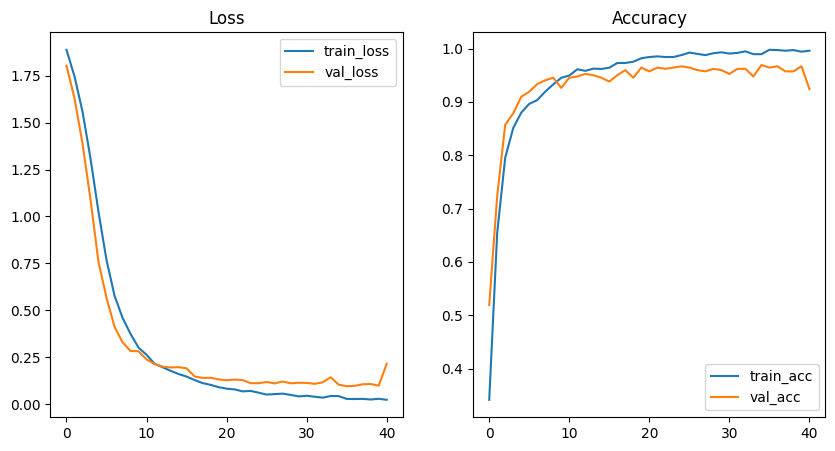

In [35]:
# Plot loss curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(logs['train_loss'])
plt.plot(logs['val_loss'])
plt.legend(['train_loss', 'val_loss'])
# plot acc
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(logs['train_acc'])
plt.plot(logs['val_acc'])
plt.legend(['train_acc', 'val_acc'])
plt.show()

#### Save and load the model



1.   Save model weights only
2.   Save with model class architecture



1. Save model weights only

In [36]:
# Save model weights
PATH = './model_weights.pth'
torch.save(model.state_dict(), PATH)

In [37]:
model.state_dict()

OrderedDict([('features.0.0.weight',
              tensor([[[[ 8.8623e-01,  1.1587e+00,  1.0086e+00],
                        [ 9.5133e-01,  1.2138e+00,  9.6058e-01],
                        [ 5.5377e-02,  1.4693e-01,  1.4953e-02]],
              
                       [[-7.8563e-01, -9.8526e-01, -8.6559e-01],
                        [-8.1458e-01, -1.0098e+00, -7.9351e-01],
                        [-6.6569e-02, -1.3062e-01, -3.5650e-02]],
              
                       [[-4.4547e-02, -6.7439e-02, -6.5429e-02],
                        [-6.1537e-02, -7.7948e-02, -6.4442e-02],
                        [-1.3244e-02, -9.6169e-03,  1.7325e-02]]],
              
              
                      [[[-4.0217e-02, -2.4008e-02, -2.1460e-02],
                        [ 3.8071e-01,  7.3066e-01,  4.1040e-01],
                        [-3.8208e-01, -7.1690e-01, -4.0002e-01]],
              
                       [[ 2.8993e-03,  8.2087e-03, -1.1995e-02],
                        [ 7.9600e-01, 

In [38]:
# load model weights
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

2. Save with model class architecture

In [39]:
torch.save(model, 'model.pth')

model = torch.load('model.pth')

#### Evaluation

In [40]:
model = model.to(device) # move model to GPU
model.eval() # Set model to evaluation mode
# Create temp tensor
y_true = torch.tensor([], dtype=torch.long).to(device)
y_pred_logits = torch.tensor([]).to(device)

# deactivate autograd engine and reduce memory usage and speed up computations
with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        pred = model(x)
        # Concatenate Ground truth and prediction
        y_true = torch.cat((y_true, y), dim=0)
        y_pred_logits = torch.cat((y_pred_logits, pred), dim=0)

y_pred_cls = y_pred_logits.argmax(1) # get class idx with max prob (100, 3) -> (100, )
y_pred_probs = nn.Softmax(dim=1)(y_pred_logits) # convert logits to probability

# Move tensor to CPU and convert to np.ndarray
y_true = y_true.cpu().numpy()
y_pred_cls = y_pred_cls.cpu().numpy()
y_pred_probs = y_pred_probs.cpu().numpy()


In [41]:
# Shape
y_true.shape, y_pred_probs.shape, y_pred_cls.shape

((420,), (420, 7), (420,))

In [42]:
# calculate ACC
acc = sum(y_true == y_pred_cls) / len(y_true)
acc

0.9238095238095239

In [43]:
from sklearn.metrics import confusion_matrix
import pandas as pd

pd.DataFrame(confusion_matrix(y_true, y_pred_cls))

,0,1,2,3,4,5,6
0,54,4,0,0,2,0,0
1,0,60,0,0,0,0,0
2,0,7,50,0,0,0,3
3,0,1,0,58,0,1,0
4,2,2,0,0,55,0,1
5,0,2,0,2,0,56,0
6,0,1,0,1,3,0,55
